<a href="https://colab.research.google.com/github/ritwikraha/computer-needs-glasses/blob/master/image-generation/Understanding-Tasks-in-Diffusers-Part-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This is the third part of the three part series on Understanding Tasks ins Diffusers. Today we are looking at a special kind of tasks known as ControlNet.

Imagine being able to prompt your image generations with the spatial information of the images along with texts for better guidance.

This unlocks the ability to use edges, depths and other spatial cues that mimic the original picture.

### Why not image-to-image?


> The answer is Control. Yes, that gives the architecture its name.

> ControlNet improves text-to-image generation by adding user control. Traditional models create impressive visuals but lack precision. ControlNet allows extra information, like sketches or depth data, to be included alongside text descriptions. This guides the model to create images that better match the user's idea.  Imagine creating a basic outline and letting the AI turn it into a complete image. This opens possibilities in art, design, and simulations, giving users more control over the final image

#### A note of acknowledgement: This tutorial has been in-part inspired by the official documentation from [HuggingFace diffusers](https://huggingface.co/blog/controlnet).



# ControlNet Models

The method of ControlNet was introduced in the paper [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543) by Lvmin Zhang and Maneesh Agrawala.

It introduces a framework that allows for supporting various spatial contexts that can serve as additional conditionings to Diffusion models such as Stable Diffusion.

- The entire code base is open sourced [here](https://github.com/lllyasviel/ControlNet#controlnet)

- Over the past year an insane number of applications of custome controlnet models have been put forth by the community. Here is a non-exhaustive list of some of the [colab notebooks](https://github.com/camenduru/controlnet-colab).


A sample from the training set for ControlNet-like training looks like this (additional conditioning is via edge maps):

<table>
<tr style="text-align: center;">
    <th>Prompt</th>
    <th>Original Image</th>
    <th>Conditioning</th>
</tr>
<tr style="text-align: center;">
     <td style="vertical-align: middle">"bird"</td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/original_bird.png" width=200/></td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/canny_map.png" width=200/></td>
</tr>
</table>

Similarly, if we were to condition ControlNet with semantic segmentation maps, a training sample would be like so:

<table>
<tr style="text-align: center;">
    <th>Prompt</th>
    <th>Original Image</th>
    <th>Conditioning</th>
</tr>
<tr style="text-align: center;">
    <td style="vertical-align: middle">"big house"</td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/original_house.png" width=300/></td>
    <td><img class="mx-auto" src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/blog/controlnet/segmentation_map.png" width=300/></td>
</tr>
</table>

Any type of conditioning requires training a new copy of ControlNet weights.
The original paper proposed 8 different conditioning models that are all [supported](https://huggingface.co/lllyasviel?search=controlnet) in Diffusers!





So with all the possible applications and outcomes of ControlNet, let us look at how we can use various ControlNet Models to generate images precisely how we want.

Although as mentioned before the official paper and corresponding repository has 8 different controlnet models, in this tutorial we will be looking at 4 of the most popular and well used models like:

1. Canny ControlNet
2. Pose ControlNet
3. Depth ControlNet
4. Segmentation-Map ControlNet

## Setup and Imports

In [ ]:
!pip install -q diffusers transformers xformers accelerate

In [ ]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

In [ ]:
import torch
import cv2
import numpy as np
from PIL import Image
from transformers import pipeline, AutoImageProcessor, UperNetForSemanticSegmentation
from diffusers import UniPCMultistepScheduler
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from controlnet_aux import OpenposeDetector, HEDdetector

**Installation:**

We install libraries for diffusion models (`diffusers`, `transformers`), computer vision (`opencv-contrib-python`), and a custom library (`controlnet_aux`).

**Imports:**

We import functionalities from these libraries to work with images (`torch`, `cv2`, `numpy`, `PIL`), potentially use pre-trained models (`transformers`), and leverage diffusion models with control (`diffusers`, `controlnet_aux`).


## Utility Functions

These functions provide helpful tools for processing images:

In [3]:
def create_canny_image(image):
    image = np.array(image)
    low_threshold = 100
    high_threshold = 200
    image = cv2.Canny(image, low_threshold, high_threshold)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    canny_image = Image.fromarray(image)
    return canny_image

**1. create_canny_image(image):**

This function takes an image as input and returns a new image highlighting its edges. Here's a breakdown of what it does:

   - We convert the image to a NumPy array for easier manipulation with OpenCV.
   - We define two thresholds, `low_threshold` and `high_threshold`, to control the sensitivity of edge detection. Lower values detect more edges, while higher values detect only strong edges.
   - We use OpenCV's `cv2.Canny` function to apply the Canny edge filter with the defined thresholds, effectively identifying edges in the image.
   - Since OpenCV's `Canny` returns a single-channel grayscale image, we convert it to a three-channel RGB image (required for the `PIL.Image` library) by duplicating the channel.
   - We create a new `PIL.Image` object from the processed NumPy array, resulting in an image with highlighted edges.
   - Finally, the function returns this new edge-enhanced image.


In [4]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

**2. image_grid(imgs, rows, cols):**

This function takes a list of images (`imgs`), the desired number of rows (`rows`), and columns (`cols`) and arranges them into a single grid image. Here's what it does:

   - We first check if the total number of images (`len(imgs)`) matches the product of rows and columns (ensuring we have enough images to fill the grid).
   - We then retrieve the width (`w`) and height (`h`) of the first image as a reference for the grid size.
   - We create a new empty `PIL.Image` object in RGB mode with dimensions calculated by multiplying the number of columns by the image width and rows by the image height, effectively creating a canvas for the grid.
   - We iterate through each image in the list and paste it onto the grid image at the corresponding position determined by its index (`i`). The modulo (`%`) operation calculates the column position, and integer division (`//`) calculates the row position within the grid.
   - Finally, the function returns the combined grid image containing all the input images arranged as specified.


In [5]:
def delete_pipeline(pipeline):
    pipeline.to("cpu")
    del pipeline
    torch.cuda.empty_cache()






**3. delete_pipeline(pipeline):**

This function takes a loaded Stable Diffusion pipeline (`pipeline`) as input and properly removes it from memory. Here's what it does:

   - First, we move the pipeline to the CPU (if it was previously on the GPU) to avoid memory leaks.
   - Then, we use the `del` statement to explicitly delete the pipeline object, freeing up the memory it occupied.
   - Lastly, we call `torch.cuda.empty_cache()` to ensure any remaining cached GPU memory associated with the pipeline is cleared as well. This helps maintain efficient memory usage, especially when dealing with multiple pipelines.


## Canny ControlNet


This code snippet demonstrates how to leverage a pre-trained diffusion model along with a control network to generate images based on a prompt while incorporating edge information from another image. Let's break down the steps:

In [6]:
prompt = "Oppenheimer as an anime character, high definition best quality, extremely detailed"

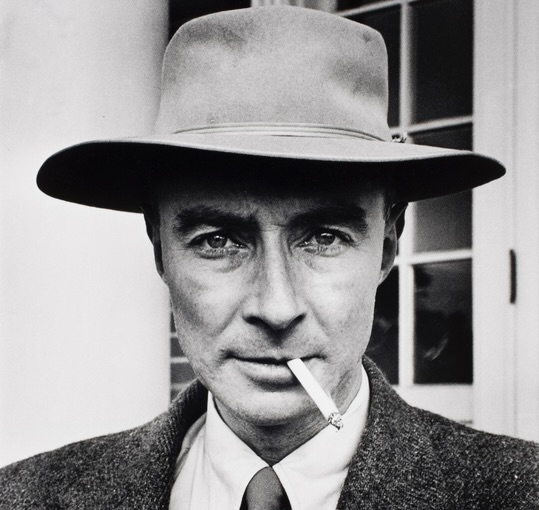

In [9]:
image = load_image(
    "https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/oppenheimer.png"
)
image

**1. Setting Up:**

   - We define a prompt describing the desired image ("Oppenheimer as an anime character, high definition best quality, extremely detailed").
   - We load an image of Oppenheimer ("[https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/oppenheimer.png](https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/oppenheimer.png)") using the `load_image` function.
   - We create a new image highlighting the edges of the loaded image using the `create_canny_image` function. This edge information will be used to guide the diffusion process.


In [10]:
canny_image = create_canny_image(image)
canny_image

In [11]:
controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

**2. Loading the Model:**

   - We load a pre-trained `ControlNetModel` called "sd-controlnet-canny" from the  Hugging Face Hub. This model is specifically designed to work with Canny edge images for control.
   - We load a pre-trained Stable Diffusion pipeline ("runwayml/stable-diffusion-v1-5") and integrate the loaded `controlnet` model into the pipeline. We also specify `torch.float16` for using a lower-precision data type to save memory if possible on your hardware.

   **3. Optimizing the Pipeline:**

   - We configure the pipeline's scheduler using `UniPCMultistepScheduler.from_config` for potentially better performance during image generation.
   - We enable CPU offloading (`enable_model_cpu_offload`) to move the model to the CPU if a GPU is available, potentially improving memory usage on systems with limited GPU memory.
   - We enable memory-efficient attention (`enable_xformers_memory_efficient_attention`) to reduce memory consumption during image generation, especially for larger image sizes.

  0%|          | 0/20 [00:00<?, ?it/s]

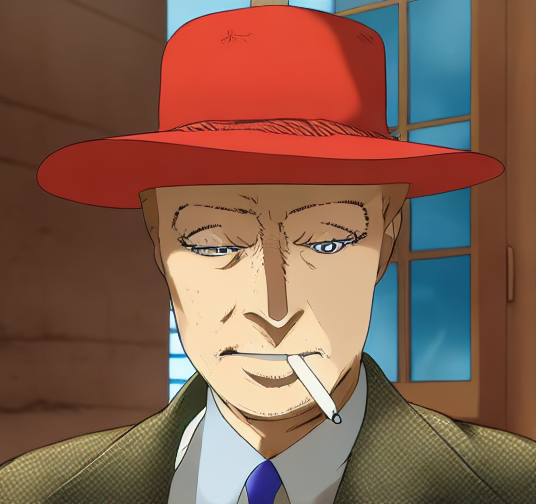

In [12]:
output = pipe(
    prompt,
    canny_image,
    negative_prompt="monochrome, low quality, lowres, bad anatomy, worst quality, low quality",
    num_inference_steps=20,
).images[0]

output

**4. Image Generation:**

   - We use the pipeline (`pipe`) to generate an image based on the provided prompt (`prompt`).
   - We also include the created canny image (`canny_image`) as an additional input to the pipeline. This injects the edge information to guide the diffusion process towards generating an image that aligns with the edges.
   - We provide a negative prompt ("monochrome, low quality, lowres, bad anatomy, worst quality, low quality") to steer the generation away from unwanted qualities.
   - We set the number of inference steps (`num_inference_steps`) to 20, which controls the detail and quality of the generated image (more steps typically lead to better results but take longer).
   - Finally, we run the pipeline and store the generated image in the `output` variable.

In [13]:
delete_pipeline(pipe)



**5. Cleaning Up:**

   - After using the pipeline, we call the `delete_pipeline` function to properly remove it from memory and free up resources, especially important when dealing with multiple pipelines.

This code effectively combines the power of Stable Diffusion for image generation with the control capabilities of Canny ControlNet to produce an image based on the prompt while incorporating the edge information from the provided Oppenheimer image.

## Pose ControlNet

This code demonstrates using a pre-trained diffusion model with a control network that leverages human pose information for image generation. Let's break it down step by step:

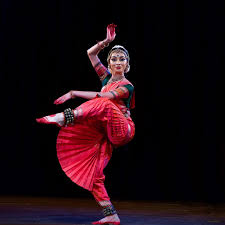

In [14]:
img_pose = load_image("https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/dancer.png")
img_pose

**1. Load Dancer Image:**

   - We load an image of a dancer ("[https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/dancer.png](https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/dancer.png)") using the `load_image` function.

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

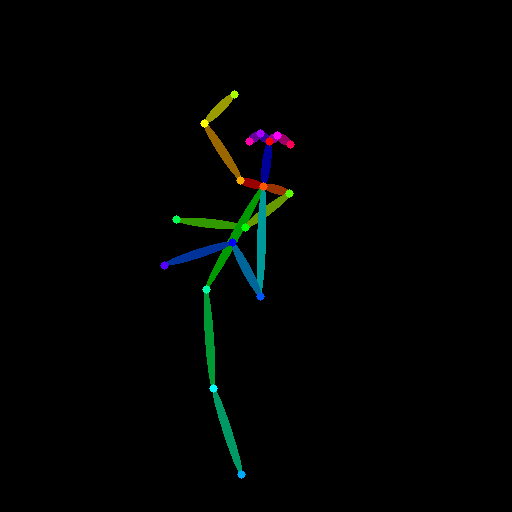

In [15]:
model = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
pose = model(img_pose)
pose

**2. Detect Pose:**

   - We load a pre-trained `OpenposeDetector` model called "lllyasviel/ControlNet". This model is designed to detect human poses from images.
   - We call the model (`model`) on the loaded image (`img_pose`) to extract the human pose information.
   - The output (`pose`) likely contains data representing the detected keypoints (e.g., shoulders, elbows, wrists) of the person in the image.

In [16]:
controlnet = ControlNetModel.from_pretrained(
    "fusing/stable-diffusion-v1-5-controlnet-openpose", torch_dtype=torch.float16
)

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    torch_dtype=torch.float16,
)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()
pipe.enable_xformers_memory_efficient_attention()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

**3. Load ControlNet Model:**

   - We load a pre-trained `ControlNetModel` called "fusing/stable-diffusion-v1-5-controlnet-openpose" specifically designed to work with Openpose data for control. This model will use the extracted pose information to guide the image generation process.

**4. Load and Configure Pipeline:**

   - We define the Stable Diffusion model ID ("runwayml/stable-diffusion-v1-5").
   - We create a `StableDiffusionControlNetPipeline` using the loaded `controlnet` model and the specified model ID. We also specify `torch.float16` to potentially save memory.
   - We configure the pipeline's scheduler using `UniPCMultistepScheduler.from_config` for potentially better performance.
   - We enable CPU offloading (`enable_model_cpu_offload`) and memory-efficient attention (`enable_xformers_memory_efficient_attention`) for potential memory savings.

In [23]:
prompt = "illustration of superman flying to the sky, high definition best quality, extremely detailed"
output = pipe(
    prompt,
    pose,
    negative_prompt="monochrome, blurry, unclear face, missing body parts, extra digits, extra eyes, ugly, lowres, bad anatomy, worst quality, low quality",
    num_inference_steps=50,
).images[0]
output

  0%|          | 0/50 [00:00<?, ?it/s]

**5. Image Generation:**

   - We define a prompt describing the desired image ("illustration of superman flying to the sky, high definition best quality, extremely detailed").
   - We use the pipeline (`pipe`) to generate an image.
   - We provide the prompt (`prompt`) and the extracted pose information (`pose`) as inputs to the pipeline. The pose information will be used by the control network to influence the generation process, potentially aligning the generated Superman with a similar pose as the dancer in the loaded image.
   - We include a negative prompt ("monochrome, blurry, unclear face, missing body parts, extra digits, extra eyes, ugly, lowres, bad anatomy, worst quality, low quality") to steer the generation away from unwanted features.
   - We set the number of inference steps (`num_inference_steps`) to 50 for potentially higher quality results (may take longer).
   - Finally, we run the pipeline and store the generated image in the `output` variable.


In [24]:
delete_pipeline(pipe)

**6. Cleaning Up:**

   - After using the pipeline, we call the `delete_pipeline` function to properly remove it from memory and free up resources.

This code effectively combines pose estimation, control networks, and Stable Diffusion to generate an image based on a prompt while incorporating the pose information from a reference image. This can be useful for creating images where the subject adopts a specific pose.

## Depth ControlNet



This code snippet demonstrates leveraging a pre-trained diffusion model with a control network that utilizes depth map to guide image generation. Here's a breakdown:

In [32]:
depth_estimator = pipeline('depth-estimation')

image = load_image("https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/ansel.png")

image = depth_estimator(image)['depth']
image = np.array(image)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
image = Image.fromarray(image)

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extr

**1. Load Depth Estimation Model:**

   - We first load a pre-trained pipeline component (`depth-estimation`) likely using a model from the Hugging Face Hub. This component is responsible for estimating depth information from an image.

**2. Load Image and Extract Depth:**

   - We load an image of Ansel ("[https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/ansel.png](https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/ansel.png)") using `load_image`.
   - We use the loaded pipeline (`depth_estimator`) on the image to extract the estimated depth information. The output (`image`) likely contains a single-channel grayscale image representing the predicted depth, where brighter values indicate closer objects.
   - We convert the depth image to a NumPy array for further processing.
   - To make it compatible with the `PIL.Image` library, we convert the single-channel depth image to a three-channel RGB image by duplicating the channel and then create a new `PIL.Image` object from the processed array.

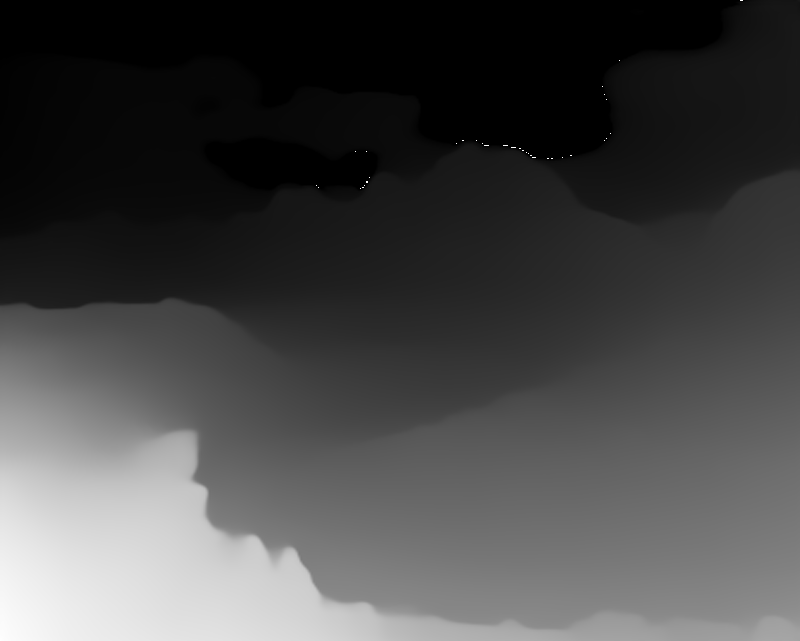

In [33]:
image

In [34]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-depth", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)


pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


**3. Load ControlNet Model:**

   - We load a pre-trained `ControlNetModel` called "lllyasviel/sd-controlnet-depth" specifically designed to work with depth information for control. This model will use the estimated depth to influence how the diffusion process generates the image.

**4. Load and Configure Pipeline (Skipping Safety Check):**

   - We create a `StableDiffusionControlNetPipeline` using the loaded `controlnet` model and the specified Stable Diffusion model ID ("runwayml/stable-diffusion-v1-5"). We also specify `torch.float16` for potential memory savings.
   - **Important Note:** We disable the `safety_checker` by setting it to `None`. This is likely for demonstration purposes only, and safety checks are generally recommended to prevent generating potentially harmful content.
   - We configure the pipeline's scheduler using `UniPCMultistepScheduler.from_config` for potentially better performance.
   - We enable memory-efficient attention (`enable_xformers_memory_efficient_attention`) and CPU offloading (`enable_model_cpu_offload`) for potential memory savings.

In [35]:
output = pipe("a looming mountain range, animated, high definition, high quality",
              image,
              negative_prompt ="monochrome, blurry, unclear face, missing body parts, extra digits, extra eyes, ugly, lowres, bad anatomy, worst quality, low quality",
              num_inference_steps=60).images[0]
output

  0%|          | 0/60 [00:00<?, ?it/s]

**5. Image Generation:**

   - We define a prompt describing the desired image ("a looming mountain range, animated, high definition, high quality").
   - We use the pipeline (`pipe`) to generate an image.
   - We provide the prompt (`prompt`) and the extracted depth information (`image`) as inputs to the pipeline. The control network will use the depth information to potentially influence the generated image, emphasizing areas with predicted closer depth (potentially making the mountain range appear more prominent).
   - We include a negative prompt ("monochrome, blurry, unclear face, missing body parts, extra digits, extra eyes, ugly, lowres, bad anatomy, worst quality, low quality") to steer the generation away from unwanted features.
   - We set the number of inference steps (`num_inference_steps`) to 60 for potentially higher quality results (may take longer).
   - Finally, we run the pipeline and store the generated image in the `output` variable.


In [36]:
delete_pipeline(pipe)

**6. Cleaning Up:**

   - After using the pipeline, we call the `delete_pipeline` function to properly remove it from memory and free up resources.

**Important Note:** Disabling the safety checker is not recommended for real-world applications. It's crucial to ensure responsible use of these models and avoid generating harmful content.

## Segmentation Map ControlNet


This code snippet demonstrates leveraging a pre-trained diffusion model with a control network that utilizes segmentation information to guide image generation. Here's a breakdown of the steps:


### Load the Palette

In [37]:
palette = np.asarray([
    [0, 0, 0],
    [120, 120, 120],
    [180, 120, 120],
    [6, 230, 230],
    [80, 50, 50],
    [4, 200, 3],
    [120, 120, 80],
    [140, 140, 140],
    [204, 5, 255],
    [230, 230, 230],
    [4, 250, 7],
    [224, 5, 255],
    [235, 255, 7],
    [150, 5, 61],
    [120, 120, 70],
    [8, 255, 51],
    [255, 6, 82],
    [143, 255, 140],
    [204, 255, 4],
    [255, 51, 7],
    [204, 70, 3],
    [0, 102, 200],
    [61, 230, 250],
    [255, 6, 51],
    [11, 102, 255],
    [255, 7, 71],
    [255, 9, 224],
    [9, 7, 230],
    [220, 220, 220],
    [255, 9, 92],
    [112, 9, 255],
    [8, 255, 214],
    [7, 255, 224],
    [255, 184, 6],
    [10, 255, 71],
    [255, 41, 10],
    [7, 255, 255],
    [224, 255, 8],
    [102, 8, 255],
    [255, 61, 6],
    [255, 194, 7],
    [255, 122, 8],
    [0, 255, 20],
    [255, 8, 41],
    [255, 5, 153],
    [6, 51, 255],
    [235, 12, 255],
    [160, 150, 20],
    [0, 163, 255],
    [140, 140, 140],
    [250, 10, 15],
    [20, 255, 0],
    [31, 255, 0],
    [255, 31, 0],
    [255, 224, 0],
    [153, 255, 0],
    [0, 0, 255],
    [255, 71, 0],
    [0, 235, 255],
    [0, 173, 255],
    [31, 0, 255],
    [11, 200, 200],
    [255, 82, 0],
    [0, 255, 245],
    [0, 61, 255],
    [0, 255, 112],
    [0, 255, 133],
    [255, 0, 0],
    [255, 163, 0],
    [255, 102, 0],
    [194, 255, 0],
    [0, 143, 255],
    [51, 255, 0],
    [0, 82, 255],
    [0, 255, 41],
    [0, 255, 173],
    [10, 0, 255],
    [173, 255, 0],
    [0, 255, 153],
    [255, 92, 0],
    [255, 0, 255],
    [255, 0, 245],
    [255, 0, 102],
    [255, 173, 0],
    [255, 0, 20],
    [255, 184, 184],
    [0, 31, 255],
    [0, 255, 61],
    [0, 71, 255],
    [255, 0, 204],
    [0, 255, 194],
    [0, 255, 82],
    [0, 10, 255],
    [0, 112, 255],
    [51, 0, 255],
    [0, 194, 255],
    [0, 122, 255],
    [0, 255, 163],
    [255, 153, 0],
    [0, 255, 10],
    [255, 112, 0],
    [143, 255, 0],
    [82, 0, 255],
    [163, 255, 0],
    [255, 235, 0],
    [8, 184, 170],
    [133, 0, 255],
    [0, 255, 92],
    [184, 0, 255],
    [255, 0, 31],
    [0, 184, 255],
    [0, 214, 255],
    [255, 0, 112],
    [92, 255, 0],
    [0, 224, 255],
    [112, 224, 255],
    [70, 184, 160],
    [163, 0, 255],
    [153, 0, 255],
    [71, 255, 0],
    [255, 0, 163],
    [255, 204, 0],
    [255, 0, 143],
    [0, 255, 235],
    [133, 255, 0],
    [255, 0, 235],
    [245, 0, 255],
    [255, 0, 122],
    [255, 245, 0],
    [10, 190, 212],
    [214, 255, 0],
    [0, 204, 255],
    [20, 0, 255],
    [255, 255, 0],
    [0, 153, 255],
    [0, 41, 255],
    [0, 255, 204],
    [41, 0, 255],
    [41, 255, 0],
    [173, 0, 255],
    [0, 245, 255],
    [71, 0, 255],
    [122, 0, 255],
    [0, 255, 184],
    [0, 92, 255],
    [184, 255, 0],
    [0, 133, 255],
    [255, 214, 0],
    [25, 194, 194],
    [102, 255, 0],
    [92, 0, 255],
])


In [38]:
image_processor = AutoImageProcessor.from_pretrained("openmmlab/upernet-convnext-small")
image_segmentor = UperNetForSemanticSegmentation.from_pretrained("openmmlab/upernet-convnext-small")

preprocessor_config.json:   0%|          | 0.00/372 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/8.76k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/328M [00:00<?, ?B/s]

**1. Load Segmentation Model and Palette:**

   - We define a color palette (`palette`) containing a large number of colors mapped to different segment labels. This palette will be used later to colorize the segmentation output.
   - We load a pre-trained `AutoImageProcessor` and a `UperNetForSemanticSegmentation` model from the OpenMMLab library. These models are likely trained for semantic segmentation, which aims to classify each pixel in an image into a specific category (e.g., sky, water, building).

### Generate Segmentation Map

In [39]:
image = load_image("https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/sydney.png").convert('RGB')
pixel_values = image_processor(image, return_tensors="pt").pixel_values

In [40]:
with torch.no_grad():
  outputs = image_segmentor(pixel_values)

seg = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3

for label, color in enumerate(palette):
    color_seg[seg == label, :] = color

color_seg = color_seg.astype(np.uint8)

image = Image.fromarray(color_seg)

In [41]:
image

**2. Load and Segment Image:**

   - We load an image of Sydney Opera House ("[https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/sydney.png](https://huggingface.co/datasets/ritwikraha/random-storage/resolve/main/sydney.png)") and convert it to RGB format (required for the segmentation model).
   - We use the loaded image processor (`image_processor`) to prepare the image for the segmentation model by converting it to a format the model expects (tensors).
   - We disable gradient calculation (`with torch.no_grad()`) to improve efficiency as we're not backpropagating through the segmentation model in this case.
   - We use the segmentation model (`image_segmentor`) to predict a segmentation mask for the image. This mask assigns a label to each pixel, potentially representing categories like sky, water, building, etc.
   
**3. Process and Colorize Segmentation:**

   - We use the image processor's post-processing function (`post_process_semantic_segmentation`) to convert the raw segmentation output from the model into a more usable format.
   - We create a new empty image (`color_seg`) with dimensions matching the segmentation mask and set the data type to unsigned 8-bit integers for efficient color representation.
   - We iterate through each unique label in the segmentation mask and its corresponding color from the defined palette (`palette`).
   - For each pixel in the segmentation mask, we assign the corresponding color from the palette based on the predicted label, effectively creating a color-coded segmentation image where different colors represent different predicted categories.
   - Finally, we convert the colorized segmentation image to an `Image` object for further use.

### Loading the ControlNet pipeline

In [42]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-seg", torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, safety_checker=None, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

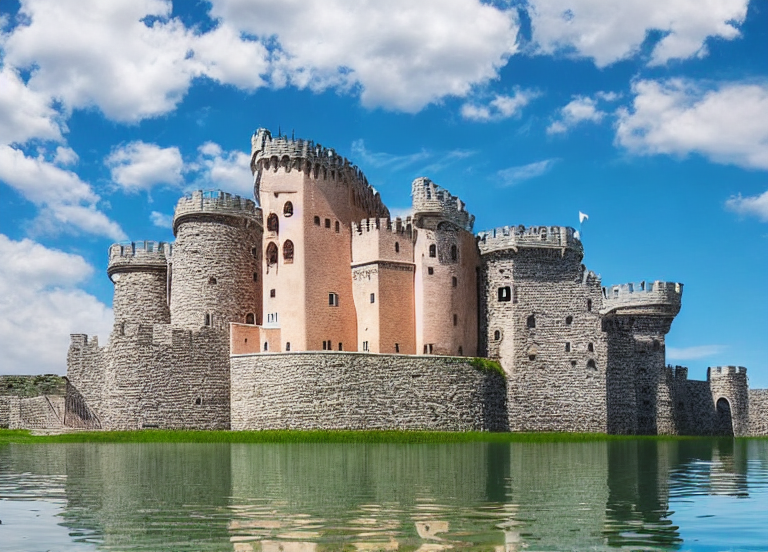

In [45]:
output = pipe("a magnificient castle on a lake with clear sky above",
              image,
              num_inference_steps=50).images[0]
output

**4. Load ControlNet and Pipeline (Skipping Safety Check):**

   - We load a pre-trained `ControlNetModel` called "lllyasviel/sd-controlnet-seg" specifically designed to work with segmentation information for control. This model will use the segmentation information to influence how the diffusion process generates the image.
   - We create a `StableDiffusionControlNetPipeline` using the loaded `controlnet` model and the specified Stable Diffusion model ID ("runwayml/stable-diffusion-v1-5"). We also specify `torch.float16` for potential memory savings.
   - **Important Note:** We disable the `safety_checker` by setting it to `None`. This is likely for demonstration purposes only, and safety checks are generally recommended to prevent generating potentially harmful content.
   - We configure the pipeline's scheduler using `UniPCMultistepScheduler.from_config` for potentially better performance.
   - We enable memory-efficient attention (`enable_xformers_memory_efficient_attention`) and CPU offloading (`enable_model_cpu_offload`) for potential memory savings.

**5. Image Generation:**

   - We define a prompt describing the desired image ("a magnificent castle on a lake with clear sky above").
   - We use the pipeline (`pipe`) to generate an image.
   - We provide the prompt (`prompt`) and the colorized segmentation image (`image`) as inputs to the pipeline. The control network will use the segmentation information to potentially influence the generated image, aligning certain aspects with the predicted categories in the segmentation (e.g., placing the castle on a region predicted as water in the segmentation).
   - We set the number of inference steps (`num_inference_steps`) to 50 for potentially higher quality results (may take longer).
   - Finally, we run the pipeline and store the generated image in the `output` variable.

In [46]:
delete_pipeline(pipe)

**6. Cleaning Up:**

   - After using the pipeline, we call the `delete_pipeline` function to properly remove it from memory and free up resources.

**Important Note:** Disabling the safety checker is not recommended for real-world applications. It's crucial to ensure responsible use of these models and avoid generating harmful content.

# Summary

As we close this chapter, let us rewind to understand what was the primary

### Applications of ControlNet in the Industry

Also here are some detailed practical applications of ControlNet across various fields:

### 1. **Personalized Media and Advertising**
- **Application**: Customized content generation for marketing and advertising.
- **Technical Details**: ControlNet can be used to adapt promotional materials to reflect diverse consumer profiles or scenarios, effectively personalizing advertising imagery to suit different demographics, locations, and individual preferences.
- **Example**:
Using ControlNet to generate custom images of products in settings that align with the target audience’s lifestyle, such as changing the background or contextual elements of an image to fit urban or rural settings.

### 2. **Interactive Entertainment and Gaming**
- **Application**: Dynamic environment generation based on player interaction and choices.
- **Technical Details**: In video games or VR environments, ControlNet can dynamically modify visuals in real-time to adapt to player inputs or narrative changes, enhancing the immersive experience.
- **Example**:
Adjusting the appearance and style of game environments and characters based on player decisions or environmental factors, enhancing the game's adaptability and engagement.

### 3. **Automotive Industry**
- **Application**: Enhanced simulation for autonomous vehicle testing.
- **Technical Details**: ControlNet can generate varied traffic scenarios under different conditions during the simulation phase of autonomous vehicle development, improving the robustness of the vehicles’ perception systems.
- **Example**:
Simulating different weather conditions, traffic densities, and pedestrian scenarios to train autonomous driving systems, helping them adapt to real-world variables.

### 4. **Medical Imaging**
- **Application**: Customizable medical training tools and enhanced diagnostic visuals.
- **Technical Details**: For medical training and diagnostics, ControlNet can be employed to generate anatomically accurate images under various simulated medical conditions, aiding in education and diagnostic processes.
- **Example**:
Creating detailed and condition-specific images like varying stages of a disease or responses to treatments, which can be used for training medical professionals or for planning surgeries.

### 5. **Architectural Visualization and Urban Planning**
- **Application**: Adaptive visualization of architectural designs and urban layouts.
- **Technical Details**: Architects and planners can use ControlNet to visualize architectural projects or urban designs under different contextual scenarios like varying light conditions, seasons, or surrounding developments.
- **Example**:
Generating images of how a building would look at different times of the day or year, or simulating the visual impact of a new building on the existing urban landscape.

### 6. **Fashion and Design**
- **Application**: Tailored design visualizations reflecting contextual customer preferences.
- **Technical Details**: In fashion, ControlNet can be used to create images of apparel or products in different styles, settings, or on models of varying body types, reflecting a more diverse range of consumer profiles.
- **Example**:
Showcasing clothing items in different urban or natural settings, on models of various body types and ethnic backgrounds to cater to a global market.

These applications leverage the unique ability of ControlNet to incorporate specific, controlled variations into the generative process, enhancing both the flexibility and utility of diffusion models across a broad spectrum of industries.